### Overview

This notebook is tested using SageMaker `Studio SparkMagic - PySpark Kernel`. Please ensure that you see `PySpark (SparkMagic)` in the top right on your notebook.

This notebook does the following:

* Demonstrates how you can visually connect Amazon SageMaker Studio Sparkmagic kernel to an EMR cluster
* Explore and query data from a Hive table 
* Use the data locally

----------


When using PySpark kernel notebooks, there is no need to create a SparkContext or a HiveContext; those are all created for you automatically when you run the first code cell, and you'll be able to see the progress printed. The contexts are created with the following variable names:
- SparkContext 
- sqlContext 

----------
### PySpark magics 

The PySpark kernel provides some predefined “magics”, which are special commands that you can call with `%%` (e.g. `%%MAGIC` <args>). The magic command must be the first word in a code cell and allow for multiple lines of content. You can’t put comments before a cell magic.

For more information on magics, see [here](http://ipython.readthedocs.org/en/stable/interactive/magics.html).

#### Running locally (%%local)

You can use the `%%local` magic to run your code locally on the Jupyter server without going to Spark. When you use %%local all subsequent lines in the cell will be executed locally. The code in the cell must be valid Python code.

----------
### Livy Connection
    
Apache Livy is a service that enables easy interaction with a Spark cluster over a REST interface. It enables easy submission of Spark jobs or snippets of Spark code, synchronous or asynchronous result retrieval, as well as Spark Context management, all via a simple REST interface or an RPC client library. 
    
![image](https://livy.incubator.apache.org/assets/images/livy-architecture.png)

In [1]:
%%local
print("Demo Notebook")

Demo Notebook


### Connection to EMR Cluster

In the cell below, the code block is autogenerated. You can generate this code by clicking on the "Cluster" link on the top of the notebook and select the EMR cluster. The "j-xxxxxxxxxxxx" is the cluster id of the cluster selected. 

For our workshop we used a no-auth cluster for simplicity, but this works equally well for Kerberos, LDAP and HTTP auth mechanisms

In [ ]:
# %load_ext sagemaker_studio_analytics_extension.magics
# %sm_analytics emr connect --cluster_id j-xxxxxxxxxxxx --auth-type None 

## SparkUI
The above connection generates a presigned url for viewing the SparkUI and debugging commands throughout this notebook

## Lets start by viewing the available SparkMagic Commands

In [4]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -i variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."
pretty,%%pretty,"If the cell output is a dataframe, like df.show(), then it will pretty print the dataframe as an HTML table"


In the next cell, we will use the sqlContext that was return to use through the connection to query Hive and look at the databases and tables

In [5]:
dbs = sqlContext.sql("show databases")
dbs.show()

tables = sqlContext.sql("show tables")
tables.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
| default|movie_reviews|      false|
+--------+-------------+-----------+

In [6]:
from pyspark.sql.functions import regexp_replace, col, concat, lit
movie_reviews = sqlContext.sql("select * from movie_reviews").cache()
movie_reviews= movie_reviews.where(col('sentiment') != "sentiment")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Shape
print((movie_reviews.count(), len(movie_reviews.columns)))

# Count of both positive and negative sentiments
movie_reviews.groupBy('sentiment').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(50000, 2)
+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+

Let's look at the data size and size of each class (positive and negative) and visualize it. You can see that we have a balanced dataset with equal number on both classes (25000 each)

In [8]:
pos_reviews = movie_reviews.filter(movie_reviews.sentiment == 'positive').collect()
neg_reviews = movie_reviews.filter(movie_reviews.sentiment == 'negative').collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

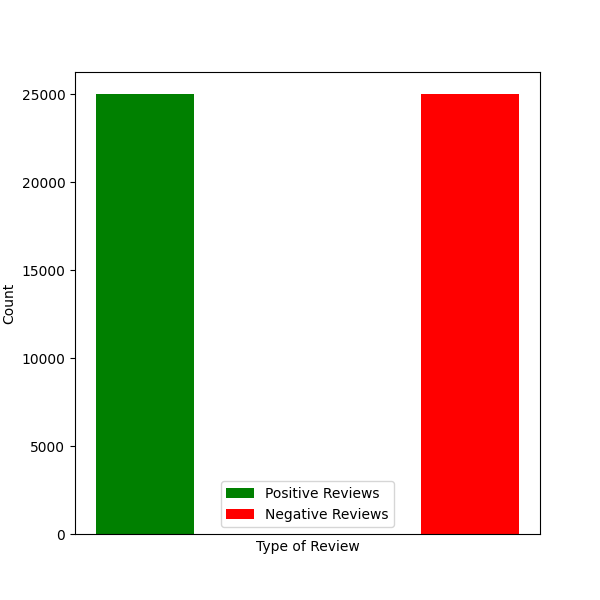

In [9]:
import matplotlib.pyplot as plt
def plot_counts(positive,negative):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,positive,width=0.6,label='Positive Reviews',color='Green')
    plt.bar(2,negative,width=0.6,label='Negative Reviews',color='Red')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylabel('Count')
    plt.xlabel('Type of Review')
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False) 
    plt.show()
    
plot_counts(len(pos_reviews),len(neg_reviews))
%matplot plt

Next, Let's inspect length of reviews using the pyspark.sql.functions module

In [10]:
from pyspark.sql.functions import length
reviewlengthDF = movie_reviews.select(length('review').alias('Length of Review')) 
reviewlengthDF.show() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|Length of Review|
+----------------+
|            1761|
|             998|
|             926|
|             748|
|            1317|
|             656|
|             726|
|             934|
|             681|
|             176|
|             578|
|             937|
|            2227|
|             662|
|             275|
|             830|
|             720|
|            1322|
|             639|
|             741|
+----------------+
only showing top 20 rows

You can also execute SparkSQL queries using the %%sql magic and pass results to a local data frame using the `-o` option. This allows for quick data exploration. Max rows returned by default is 2500. You can set the max rows by using the `-n` argument. 

In [18]:
%%sql -o movie_reviews_sparksql_df -n 10
select * from movie_reviews 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

You can access and explore the data in the dataframe locally

In [19]:
%%local 
movie_reviews_sparksql_df.head(10)

Output()

### Session logs (%%logs)

Instead of the SparkUI, you can also get the logs of your current Livy session to debug any issues you encounter.

In [ ]:
%%logs

### Session information (%%info)

Livy is an open source REST server for Spark. When you execute a code cell in a sparkmagic notebook, it creates a Livy session to execute your code. `%%info` magic will display the current Livy session information.

In [14]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
38,application_1637605257013_0040,pyspark,idle,Link,Link,None,✔


## Terminating all Livy Sessions

In [15]:
%%cleanup -f

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…